# korquad_dataset "context" 분포
- 아래 EDA는 korquad_dataset의 context 열을 roberta-large 모델 토크나이저를 Reader에서 쓴다는 가정하에 분석한 것입니다.
- Reader의 성능을 올리기 위해, context 열을 전처리할 아이디어를 찾습니다.
- 일단 korquad 1.0 데이터셋도 훈련에 쓰니까, original 데이터셋과 유사한 방법으로 분석을 진행해 보았습니다.

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
dataset = load_dataset("squad_kor_v1")
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 60407
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5774
    })
})

In [3]:
dataset['train'][0]

{'id': '6566495-0-0',
 'title': '파우스트_서곡',
 'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 'answers': {'text': ['교향곡'], 'answer_start': [54]}}

## Reader 모델에 사용할 roberta-large 토크나이저로 context 분석
- 토큰 길이 분석
- 토큰화 결과 직접 보기
- 토큰화 결과: UNK 분석

In [5]:
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

/shared/home/sw_innovation01/anaconda3/envs/odqa/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
def tokenize_and_analyze(examples):
    # Tokenize the context column
    tokenized = tokenizer(examples['context'], padding=False, truncation=False, return_length=True)
    # Count the number of UNK tokens for each example
    unk_count = [tokens.count(tokenizer.unk_token_id) for tokens in tokenized['input_ids']]
    # Return the token lengths
    return {'tokens_length': tokenized['length'], 'unk_count': unk_count}

In [7]:
train_dataset = dataset['train'].map(tokenize_and_analyze, batched=True)
validation_dataset = dataset['validation'].map(tokenize_and_analyze, batched=True)

Map:   0%|          | 0/60407 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/5774 [00:00<?, ? examples/s]

In [8]:
train_df = pd.DataFrame({
    'context': dataset['train']['context'],
    'tokens_length': train_dataset['tokens_length'],
    'unk_count': train_dataset['unk_count']
})
validation_df = pd.DataFrame({
    'context': dataset['validation']['context'],
    'tokens_length': validation_dataset['tokens_length'],
    'unk_count': validation_dataset['unk_count']
})

### 토큰 길이 분석

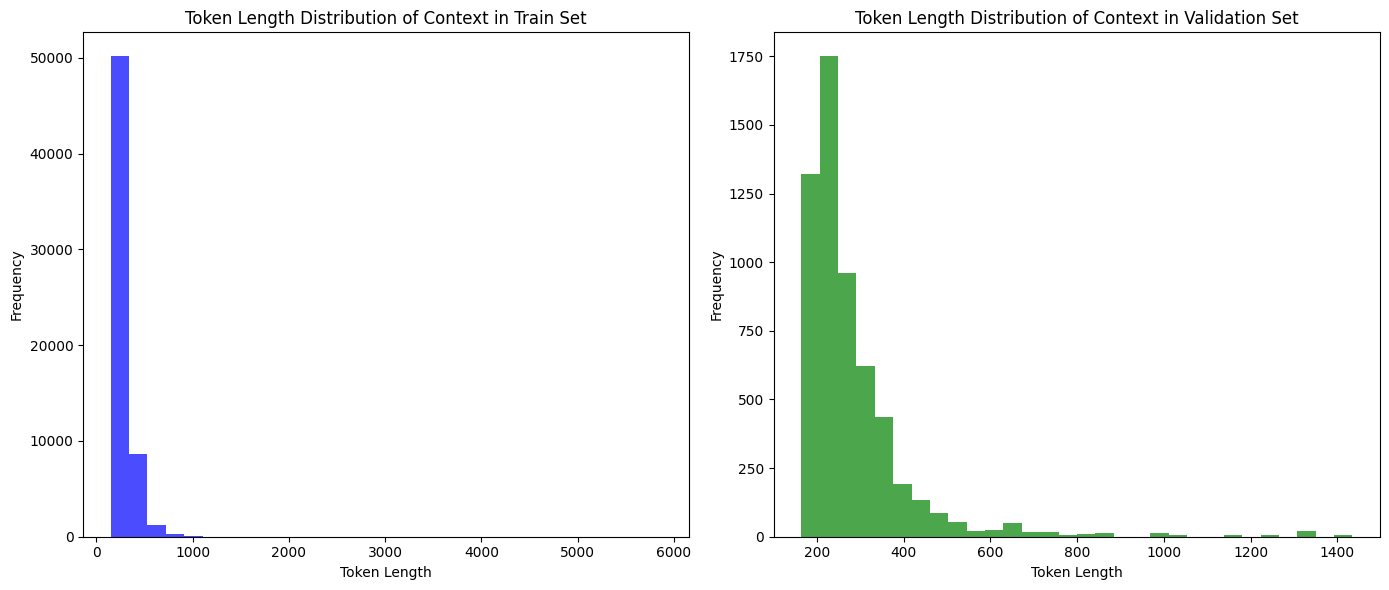

In [9]:
# Plot the distribution of token lengths for the train and validation sets side by side
plt.figure(figsize=(14, 6))

# Plot for the train set (left side)
plt.subplot(1, 2, 1)
plt.hist(train_df['tokens_length'], bins=30, alpha=0.7, color='blue')
plt.title('Token Length Distribution of Context in Train Set')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

# Plot for the validation set (right side)
plt.subplot(1, 2, 2)
plt.hist(validation_df['tokens_length'], bins=30, alpha=0.7, color='green')
plt.title('Token Length Distribution of Context in Validation Set')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [10]:
train_stats = train_df['tokens_length'].describe()
validation_stats = validation_df['tokens_length'].describe()

# 출력
print("Train set token length statistics:")
print(train_stats)
print("\nValidation set token length statistics:")
print(validation_stats)

Train set token length statistics:
count    60407.000000
mean       275.000894
std        117.574590
min        149.000000
25%        210.000000
50%        245.000000
75%        304.000000
max       5874.000000
Name: tokens_length, dtype: float64

Validation set token length statistics:
count    5774.000000
mean      283.999480
std       138.303468
min       164.000000
25%       209.000000
50%       242.000000
75%       310.000000
max      1435.000000
Name: tokens_length, dtype: float64


### UNK 개수 분석

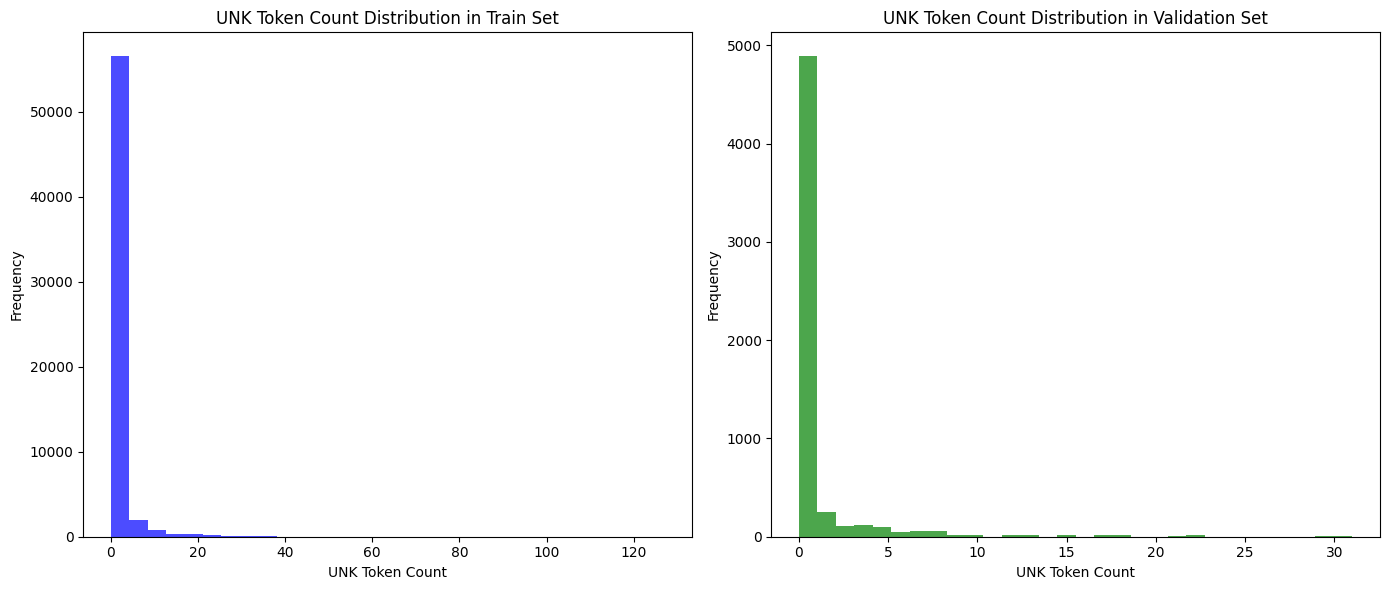

In [11]:
# Optionally, you can plot the distribution of UNK tokens in a similar way
plt.figure(figsize=(14, 6))

# Plot for the train set (left side)
plt.subplot(1, 2, 1)
plt.hist(train_df['unk_count'], bins=30, alpha=0.7, color='blue')
plt.title('UNK Token Count Distribution in Train Set')
plt.xlabel('UNK Token Count')
plt.ylabel('Frequency')

# Plot for the validation set (right side)
plt.subplot(1, 2, 2)
plt.hist(validation_df['unk_count'], bins=30, alpha=0.7, color='green')
plt.title('UNK Token Count Distribution in Validation Set')
plt.xlabel('UNK Token Count')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [12]:
# Now let's calculate and print some statistics for UNK tokens
train_unk_stats = train_df['unk_count'].describe()
validation_unk_stats = validation_df['unk_count'].describe()

train_stats = train_df['tokens_length'].describe()
validation_stats = validation_df['tokens_length'].describe()

# 출력
print("Train set unk statistics:")
print(train_unk_stats)
print("\nValidation set unk statistics:")
print(validation_unk_stats)

Train set unk statistics:
count    60407.000000
mean         1.103779
std          3.829021
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        127.000000
Name: unk_count, dtype: float64

Validation set unk statistics:
count    5774.000000
mean        1.036716
std         2.998534
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        31.000000
Name: unk_count, dtype: float64


### UNK 원본단어 분석

In [14]:
def tokenize_and_find_unk(examples):
    tokenized = tokenizer(
        examples['context'], 
        padding=False, 
        truncation=False,
        return_offsets_mapping=True
    )
    
    batch_unk_original_words = []  # To store original words mapped to UNK

    for i in range(len(tokenized['input_ids'])):
        original_text = examples['context'][i]
        word_pieces = tokenizer.tokenize(original_text)
        offsets = tokenized['offset_mapping'][i]
        tokens = tokenized['input_ids'][i]
        
        unk_original_words = []
        # Iterate over tokens and offset mapping to find [UNK] tokens
        for j, token in enumerate(tokens):
            if token == tokenizer.unk_token_id:
                # Use the offset to extract the original word that corresponds to the [UNK] token
                start, end = offsets[j]
                unk_word = original_text[start:end] if start != end else "[UNKNOWN_WORD]"
                unk_original_words.append(unk_word)
        batch_unk_original_words.append(unk_original_words)
    
    # Return a list of original words that were tokenized as [UNK]
    return {'unk_original_words': batch_unk_original_words}


In [15]:
train_dataset_unk = dataset['train'].map(tokenize_and_find_unk, batched=True, remove_columns=dataset['train'].column_names)
validation_dataset_unk = dataset['validation'].map(tokenize_and_find_unk, batched=True, remove_columns=dataset['validation'].column_names)

Map:   0%|          | 0/60407 [00:00<?, ? examples/s]

Map:   0%|          | 0/5774 [00:00<?, ? examples/s]

In [16]:
train_unk_words = [word for sublist in train_dataset_unk['unk_original_words'] for word in sublist]
validation_unk_words = [word for sublist in validation_dataset_unk['unk_original_words'] for word in sublist]

In [17]:
print('len(train_unk_words):', len(train_unk_words))
print('len(validation_unk_words):', len(validation_unk_words))

len(train_unk_words): 66676
len(validation_unk_words): 5986


In [18]:
train_unk_counter = Counter(train_unk_words)
validation_unk_counter = Counter(validation_unk_words)

In [19]:
train_unk_df = pd.DataFrame(train_unk_counter.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
validation_unk_df = pd.DataFrame(validation_unk_counter.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

In [22]:
print("Top 10 words tokenized as [UNK] in train set:")
print(train_unk_df.head(30))

Top 10 words tokenized as [UNK] in train set:
     word  count
17      –    927
175     李    557
340     皇    430
283     衛    353
174     校    227
1150  쿰스는    223
85      慶    222
205     縣    210
424     里    192
978     興    186
464     孝    176
346     永    173
76      国    169
524     殿    157
459     敬    155
82      守    150
2655    ⇒    147
271     樂    146
404     郡    146
80      良    145
450     康    144
1917    柳    143
147     숀    139
617     陳    138
726     星    137
543     洪    135
410     尹    134
57      藤    133
445     姓    132
460     建    130


In [23]:
print("\nTop 10 words tokenized as [UNK] in validation set:")
print(validation_unk_df.head(30))


Top 10 words tokenized as [UNK] in validation set:
            word  count
181            李    103
113            品     90
252            根     72
251            瞋     72
250            貪     72
36             –     65
253            薩     65
48             曆     58
335         아이튠즈     50
131            忠     49
89             賢     46
501            菩     41
247            住     40
371            企     40
175            位     39
40             藏     38
597           모뎀     37
248            欲     36
249            纏     36
206  Nürburgring     34
235            癡     32
86             功     30
334            承     30
283         쏱아졌다     29
222            勝     28
234            앎     28
186            博     27
145            派     27
17             楓     26
182            雨     26
